# Chapter 3: Introducing Snorkel

In this chapter I will introduce [Snorkel](http://snorkel.org), which we'll use throughout the book. [Snorkel](https://www.snorkel.org/) is a software project ([github](https://github.com/snorkel-team/snorkel)) originally from the Hazy Research group at Stanford University enabling the practice of *weak supervision*, *distant supervision*, *data augmentation* and *data slicing*.

The project has an excellent [Get Started](https://www.snorkel.org/get-started/) page, and I recommend you spend some time working the [tutorials](https://github.com/snorkel-team/snorkel-tutorials) before proceeding beyond this chapter. 

Snorkel implements an unsupervised generative model that accepts a matrix of weak labels for records in your training data and produces strong labels by learning the relationships between these weak labels through matrix factorization.

In [1]:
import random
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import pyarrow

from lib import utils


# Make randomness reproducible
random.seed(31337)
np.random.seed(31337)

# Ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

[nltk_data] Downloading package punkt to /Users/rjurney/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rjurney/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Example Project: Labeling Amazon Github Repositories

I have previously hand labeled about 2,600 Github repositories belonging to Amazon and its subsidiariesinto categories related to their purpose. We're going to use this dataset to introduce Snorkel.

### Hand Labeling this Data

In order to get a ground truth dataset against which to benchmark our Snorkel labeling, I hand labeled all Amazon Github projects in [this sheet](https://docs.google.com/spreadsheets/d/1wiesQSde5LwWV_vpMFQh24Lqx5Mr3VG7fk_e6yht0jU/edit?usp=sharing). The label categories are:

| Number | Code      | Description                          |
|--------|-----------|--------------------------------------|
| 0      | GENERAL   | A FOSS project of general utility    |
| 1      | API       | API library for AWS / Amazon product |
| 2      | RESEARCH  | A research paper and/or dataset      |
| 3      | DEAD      | Project is dead, no longer useful    |
| 3      | OTHER     | Uncertainty... what is this thing?   |

If you want to make corrections, please open the sheet, click on `File --> Make a Copy`, make any edits and then share the sheet with me.

In [2]:
# Show all columns to see the data menu :)
pd.options.display.max_columns = None

# Load the labeled data made up of Github API data and Github READMEs
df = pd.read_json('../data/amazon_github_repos.json.bz2', lines=True, compression='bz2')
df.head(10)

,id,node_id,name,full_name,private,owner,html_url,description,fork,url,forks_url,keys_url,collaborators_url,teams_url,hooks_url,issue_events_url,events_url,assignees_url,branches_url,tags_url,blobs_url,git_tags_url,git_refs_url,trees_url,statuses_url,languages_url,stargazers_url,contributors_url,subscribers_url,subscription_url,commits_url,git_commits_url,comments_url,issue_comment_url,contents_url,compare_url,merges_url,archive_url,downloads_url,issues_url,pulls_url,milestones_url,notifications_url,labels_url,releases_url,deployments_url,created_at,updated_at,pushed_at,git_url,ssh_url,clone_url,svn_url,homepage,size,stargazers_count,watchers_count,language,has_issues,has_projects,has_downloads,has_wiki,has_pages,forks_count,mirror_url,archived,disabled,open_issues_count,license,forks,open_issues,watchers,default_branch,permissions,score,readme,label
0,61861755,MDEwOlJlcG9zaXRvcnk2MTg2MTc1NQ==,alexa-skills-kit-sdk-for-nodejs,alexa/alexa-skills-kit-sdk-for-nodejs,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/alexa-skills-kit-sdk-...,The Alexa Skills Kit SDK for Node.js helps you...,False,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,2016-06-24 06:26:05,2020-02-21 22:20:59,2020-02-13 23:12:03,git://github.com/alexa/alexa-skills-kit-sdk-fo...,git@github.com:alexa/alexa-skills-kit-sdk-for-...,https://github.com/alexa/alexa-skills-kit-sdk-...,https://github.com/alexa/alexa-skills-kit-sdk-...,,737,2811,2811,TypeScript,True,False,True,False,False,670,NaN,False,False,8,"{'key': 'apache-2.0', 'name': 'Apache License ...",670,8,2811,2.0.x,"{'admin': False, 'push': False, 'pull': True}",1,"<p align=""center"">\n <img src=""https://m.medi...",API
1,84138837,MDEwOlJlcG9zaXRvcnk4NDEzODgzNw==,alexa-cookbook,alexa/alexa-cookbook,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/alexa-cookbook,A series of sample code projects to be used fo...,False,https://api.github.com/repos/alexa/alexa-cookbook,https://api.github.com/repos/alexa/alexa-cookb...,https://api.github.com/repos/alexa/alexa-cookb...,https://api.github.com/repos/alexa/alexa-cookb...,https://api.github.com/repos/alexa/alexa-cookb...,https://api.

In [3]:
# Trim the fields so we can see the data
df = df[[
    'id',
    'full_name',
    'description',
    'created_at',
    'updated_at',
    'homepage',
    'size',
    'stargazers_count',
    'watchers',
    'forks',
    'open_issues',
    'default_branch',
    'language',
    'has_pages',
    'archived',
    'disabled',
    'license',
    'readme',
    'label'
]]

df['license'] = df['license'].apply(lambda x: x['name'] if x and 'name' in x else '')

# Remove empties to avoid spaCy processing errors
df = df.fillna('')

# Set the index to the project ID
df = df.set_index('id')

df.head()

,full_name,description,created_at,updated_at,homepage,size,stargazers_count,watchers,forks,open_issues,default_branch,language,has_pages,archived,disabled,license,readme,label
id,,,,,,,,,,,,,,,,,,
61861755,alexa/alexa-skills-kit-sdk-for-nodejs,The Alexa Skills Kit SDK for Node.js helps you...,2016-06-24 06:26:05,2020-02-21 22:20:59,,737,2811,2811,670,8,2.0.x,TypeScript,False,False,False,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.medi...",API
84138837,alexa/alexa-cookbook,A series of sample code projects to be used fo...,2017-03-07 01:19:08,2020-02-23 04:01:25,,55015,1557,1557,912,13,master,JavaScript,False,False,False,Other,\n# Alexa Skill Building Cookbook\n\n<div styl...,API
63275452,alexa/skill-sample-nodejs-fact,Build An Alexa Fact Skill,2016-07-13 19:58:38,2020-02-24 10:27:16,,431,1002,1002,1186,7,master,JavaScript,False,False,False,Apache License 2.0,"# Build An Alexa Fact Skill\n<img src=""https:/...",API
81483877,alexa/avs-device-sdk,An SDK for commercial device makers to integra...,2017-02-09 18:57:26,2020-02-21 17:10:51,https://developer.amazon.com/avs/sdk,4212386,993,993,477,54,master,C++,True,False,False,Apache License 2.0,### What is the Alexa Voice Service (AVS)?\n\n...,API
38904647,alexa/alexa-skills-kit-sdk-for-java,The Alexa Skills Kit SDK for Java helps you ge...,2015-07-10 22:21:51,2020-02-22 01:37:41,http://developer.amazon.com/ask,1603,715,715,720,2,2.0.x,Java,False,False,False,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.medi...",API


## Profile the Data

Let's take a quick look at the labels to see what we'll be classifying.

In [4]:
print(f'Total records: {len(df.index):,}')

df['label'].value_counts()

Total records: 2,568


API         2265
GENERAL      279
DEAD          14
RESEARCH       9
OTHER          1
Name: label, dtype: int64

### How much general utility do Amazon's Github projects have?

One question that occurs to me to ask is - how much general utility do Amazon's Github projects have? Let's look at the number of `GENERAL` purpose compared to the number of `API` projects.

In [5]:
api_count     = df[df['label'] == 'API'].count(axis='index')['full_name']
general_count = df[df['label'] == 'GENERAL'].count(axis='index')['full_name']

general_pct = 100 * (general_count / (api_count + general_count))
api_pct     = 100 * (api_count / (api_count + general_count))

print(f'Percentage of projects having general utility:   {general_pct:,.3f}%')
print(f'Percentage of projects for Amazon products/APIs: {api_pct:,.3f}%')

Percentage of projects having general utility:   10.967%
Percentage of projects for Amazon products/APIs: 89.033%


### Simplify to `API` vs `GENERAL`

We throw out `DEAD`, `RESEARCH` and `OTHER` to focus on `API` vs `GENERAL` - is an open source project of general utility or is it a client to a company's commercial products? Highly imabalanced classes are hard to deal with when building a classifier, and 1:9 for `GENERAL`:`API` is bad enough.

In [6]:
df = df[df['label'].isin(['API', 'GENERAL'])]

print(f'Total records with API/GENERAL labels: {len(df.index):,}')

df.head()

Total records with API/GENERAL labels: 2,544


,full_name,description,created_at,updated_at,homepage,size,stargazers_count,watchers,forks,open_issues,default_branch,language,has_pages,archived,disabled,license,readme,label
id,,,,,,,,,,,,,,,,,,
61861755,alexa/alexa-skills-kit-sdk-for-nodejs,The Alexa Skills Kit SDK for Node.js helps you...,2016-06-24 06:26:05,2020-02-21 22:20:59,,737,2811,2811,670,8,2.0.x,TypeScript,False,False,False,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.medi...",API
84138837,alexa/alexa-cookbook,A series of sample code projects to be used fo...,2017-03-07 01:19:08,2020-02-23 04:01:25,,55015,1557,1557,912,13,master,JavaScript,False,False,False,Other,\n# Alexa Skill Building Cookbook\n\n<div styl...,API
63275452,alexa/skill-sample-nodejs-fact,Build An Alexa Fact Skill,2016-07-13 19:58:38,2020-02-24 10:27:16,,431,1002,1002,1186,7,master,JavaScript,False,False,False,Apache License 2.0,"# Build An Alexa Fact Skill\n<img src=""https:/...",API
81483877,alexa/avs-device-sdk,An SDK for commercial device makers to integra...,2017-02-09 18:57:26,2020-02-21 17:10:51,https://developer.amazon.com/avs/sdk,4212386,993,993,477,54,master,C++,True,False,False,Apache License 2.0,### What is the Alexa Voice Service (AVS)?\n\n...,API
38904647,alexa/alexa-skills-kit-sdk-for-java,The Alexa Skills Kit SDK for Java helps you ge...,2015-07-10 22:21:51,2020-02-22 01:37:41,http://developer.amazon.com/ask,1603,715,715,720,2,2.0.x,Java,False,False,False,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.medi...",API


### Split our Data into Training and Validation Data

In order to demonstrate Snorkel's capabilities, we need to create an experiment by splitting our data into three datasets:

* A hand labeled development dataset `dev_df` we will use to determine if our LFs work
* An unlabeled training dataset `train_df` that Snorkel's LabelModel will use to learn the labels
* A hand labeled test dataset `test_df` used to validate that the discriminative model we train with our labeled data works

The point of Snorkel is that you don't need labels - so we won't be using labels with the training dataset, `train_df`. Therefore we delete that variable to keep ourselves honest :) We also keep the development dataset `dev_df` small to demonstrate that you only need to label a small amount of representative data.

Once we've prepared our three dataset splits, because the labeled dev dataset `dev_df` is small, we run a value count for each of its labels to verify we have an adequate number of each label. It looks like we have around ten, which will do. People use Snorkel without any labels at all but at least ten of each label is very helpful in evaluating the performance, as we code, of the data programs we'll be writing to label data/

In [7]:
from sklearn.model_selection import train_test_split

# First split into a dev/train dataset we'll split next and a test dataset for our final model
dev_train_df, test_df, train_labels, test_labels = train_test_split(
    df,
    df['label'],
    test_size=0.7
)

# Then split the dev/train data to create a small labeled dev dataset and a larger unlabeled training dataset
dev_df, train_df, dev_labels, train_labels = train_test_split(
    dev_train_df,
    dev_train_df['label'],
    test_size=0.65
)

# Make sure our split of records makes sense
print(f'Total dev records:   {len(dev_df.index):,}')
print(f'Total train records: {len(train_df.index):,}')
print(f'Total test records:  {len(test_df.index):,}')

# Remove the training data labels - normally we would not have labeled these yet - this is why we're using Snorkel!
del train_labels

# Count labels in the dev set
dev_labels.value_counts(), test_labels.value_counts()

Total dev records:   267
Total train records: 496
Total test records:  1,781


(API        235
 GENERAL     32
 Name: label, dtype: int64, API        1583
 GENERAL     198
 Name: label, dtype: int64)

## Working with Snorkel

Snorkel has three primary programming interfaces: Labeling Functions, Transformation Functions and Slicing Functions.

<img 
     alt="Snorkel Programming Interface: Labeling Functions, Transformation Functions and Slicing Functions"
     src="images/snorkel_apis_0.9.5.png"
     width="500px"
/>
<div align="center">Snorkel Programming Interface: Labeling Functions, Transformation Functions and Slicing Functions, from <a href="https://www.snorkel.org/">Snorkel.org</a></div>

### Labeling Functions (LFs)

A labeling function is a deterministic function used to label data as belonging to one class or another. They produce weak labels that in combination, through Snorkel’s generative models, can be used to generate strong labels for unlabeled data.

The [Snorkel paper](https://arxiv.org/pdf/1711.10160.pdf) explains that LFs are open ended, that is that they can leverage information from multiple sources - both inside and outside the record. For example LFs can operate over different parts of the input document, working with document metadata, entire texts, individual paragraphs, sentences or words, parts of speech, named entities extracted by preprocessors, text embeddings or any augmentation of the record whatsoever. They can simultaneously leverage external databases and rules through *distant supervision*. These might include vocabulary for keyword searches, heuristics defined by theoretical considerations or equations, 

For example, a preprocessor might run a text document through a language model such as the included `SpacyPreprocessor` to run Named Entity Resolution (NER) and then look for words queried from WikiData that correspond to a given class. There are many ways to write LFs. We’ll define a broad taxonomy and then demonstrate some techniques from each.

The program interface for Labeling Functions is [`snorkel.labeling.LabelingFunction`](https://snorkel.readthedocs.io/en/v0.9.5/packages/_autosummary/labeling/snorkel.labeling.LabelingFunction.html#snorkel.labeling.LabelingFunction). They are instantiated with a name, a function reference, any resources the function needs and a list of any preprocessors to run on the data records before the labeling function runs.

<img alt="LabelingFunction API" src="images/labeling_function_api.png" width="600" />

### Defining Labeling Schema

In order to write our first labeling function, we need to define the label schema for our problem. The first label in any labeling schema is `-1` for `ABSTAIN`, which means "cast no vote" about the class of the record. This allows Snorkel Labeling Functions to vote only when they are certain, and is critical to how the system works since labeling functions have to perform better than random when they do vote or the Label Model won't work well.

The labels for this analysis are:

| Number | Code      | Description                       |
|--------|-----------|-----------------------------------|
| -1     | ABSTAIN   | No vote, for Labeling Functions   |
| 0      | GENERAL   | A FOSS project of general appeal  |
| 1      | API       | An API library for AWS            |

In [8]:
# Define our numeric labels as integers
ABSTAIN = -1
GENERAL = 0
API     = 1


def map_labels(x):
    """Map string labels to integers"""
    if x == 'API':
        return API
    if x == 'GENERAL':
        return GENERAL


dev_labels    =   dev_labels.apply(map_labels, convert_dtype=True)
test_labels   =  test_labels.apply(map_labels, convert_dtype=True)

dev_labels.shape, test_labels.shape

((267,), (1781,))

In [9]:
# Help map back and forth between strings and integer labels
label_pairs = [
    (ABSTAIN, 'ABSTAIN'),
    (GENERAL, 'GENERAL'),
    (API, 'API'),
]

# Forward and reverse indexes to labels/names
number_to_name_dict = dict(label_pairs)
name_to_number_dict = dict([(x[1],x[0]) for x in label_pairs])

### Writing our First Labeling Function

In order to write a labeling function, we must describe our data to associate a property with a certain class of records that can be programmed as a heuristic. Let's inspect some of our records. The classes are imbalanced 9:1, so lets pull a stratified sample of both labels.

Look at the data table produced by the records below and try to eyeball any patterns among the `API` and the `GENERAL` records. Do you see any markers for `API` records or `GENERAL` records?

In [10]:
# Set Pandas to display more than 10 rows
pd.set_option('display.max_rows', 100)

api_df     = dev_df[dev_df['label'] ==     'API'].sample(frac=1).head(20).sort_values(by='label')
general_df = dev_df[dev_df['label'] == 'GENERAL'].sample(frac=1).head(10).sort_values(by='label')

api_df.append(general_df).head(30)

,full_name,description,created_at,updated_at,homepage,size,stargazers_count,watchers,forks,open_issues,default_branch,language,has_pages,archived,disabled,license,readme,label
id,,,,,,,,,,,,,,,,,,
39527199,awsdocs/elastic-beanstalk-samples,This repository contains code and configuratio...,2015-07-22 19:55:16,2020-02-23 00:35:13,,911,628,628,477,4,master,,False,False,False,Apache License 2.0,## AWS Glue Developer Guide\n\nThe open source...,API
128466427,aws-samples/microservices-webapp,Microservices Deploy Options on AWS - 3/3 micr...,2018-04-06 20:18:20,2019-01-27 09:40:53,,21,8,8,18,3,master,Java,False,False,False,Apache License 2.0,## AWS Service Catalog Tools Workshop\n\nIndep...,API
113606879,awsdocs/amazon-lex-developer-guide,The open source version of the Amazon Lex docs...,2017-12-08 18:50:32,2020-02-07 20:17:08,,446,13,13,22,4,master,,False,False,False,Other,## AWS Opsworks User Guide\n\nThe open source ...,API
170369089,aws-samples/aws-sagemaker-pytorch-shop-by-style,A Personalized 'Shop-by-Style' Experience via ...,2019-02-12 18:26:31,2020-02-17 22:22:51,,6446,18,18,9,2,master,Jupyter Notebook,False,False,False,Apache License 2.0,\n\n# Getting Started with ECS\n\n## Overview\...,API
102652582,awslabs/MXNet2CoreML_iOS_sample_app,MXNet to Core ML - iOS sample app,2017-09-06 19:59:48,2019-11-15 10:43:04,,2394,42,42,7,0,master,Swift,False,False,False,Apache License 2.0,# Is It on AWS?\n\nA couple of Lambda function...,API
55263749,aws-quickstart/quickstart-chef-automate,AWS Quick Start Team,2016-04-01 21:34:07,2020-02-01 14:12:04,,2294,6,6,14,1,master,Shell,False,False,False,Apache License 2.0,# connect-integration-spicecsm\n## Amazon Conn...,API
107435716,awslabs/voice-powered-analytics,Workshop to build voice enabled integration wi...,2017-10-18 16:40:34,2020-02-18 09:09:06,,69969,103,103,46,1,master,Python,False,False,False,Other,# Snapshot Tool for Amazon Aurora \r\n\r\nThe ...,API
175710154,aws-samples/amazon-S3-cache-with-amazon-elasti...,This sample project illustrates how you can ca...,2019-03-14 22:34:38,2019-12-27 03:42:08,,78,4,4,8,0,master,Python,False,False,False,Other,# CodeBuild Webhooks\n\nA solution for CodeBui...,API
163226093,awsdocs/aws-robomaker-developer-guide,AWS RoboMaker is a service that makes it easy ...,2018-12-26 23:36:23,2020-02-20 18:29:29,,203,0,0,3,0,master,,False,False,False,Other,## Amazon Chime Developer Guide\n\nThe open so...,API


### Detecting Patterns

In looking at the `full_name` and `html_url`, it looks like projects with `sdk` in the title are `API` projects. Lets filter down to those records to see.

In [11]:
sdk_df = dev_df[dev_df['full_name'].str.contains('sdk')]

print(f'Total SDK records: {len(sdk_df.index)}')

sdk_df.groupby('label').count()['full_name']

Total SDK records: 12


label
API    12
Name: full_name, dtype: int64

## Building an SDK Labeling Function

There is an 8:0 `API`:`GENERAL` ratio of labels among records with `sdk` in their full_name. This is more than good enough for a Labeling Function (LF), since they only have to be better than random! Cool, eh? Don't worry, the `LabelModel` will figure out which signal from which LF to use :) It's like magic!

This is called a keyword labeling function, the simplest type. Despite their simplicity, keyword LFs are incredibly powerful ways to inject subject matter expertise into a project. In the chapter on Weak Supervision, we'll get into the various types of LFs and the strategies researchers and Snorkel users have come up with for labeling data. For now we'll create this and a couple of other LFs and see where that gets us.

In [12]:
# The verbosse way to define an LF
from snorkel.labeling import LabelingFunction


sdk_lf = LabelingFunction(
    name="name_contains_sdk_lf",
    f=lambda x: API if 'sdk' in x.full_name.lower() else ABSTAIN,
)

print(sdk_lf)


# The short form way to define an LF
from snorkel.labeling import labeling_function


@labeling_function()
def name_contains_sdk_lf(x):
    return API if 'sdk' in x.full_name.lower() else ABSTAIN

print(sdk_lf)

LabelingFunction name_contains_sdk_lf, Preprocessors: []
LabelingFunction name_contains_sdk_lf, Preprocessors: []


## Testing our `LabelingFunction`

Snorkel comes with tools to help you run your LFs on your dataset to see how they perform. We're using Pandas, so we use [`snorkel.labeling.PandasLFApplier`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/labeling/snorkel.labeling.PandasLFApplier.html) to apply our list of label functions (in this case just one) to the hand-labeled development dataset `dev_df` and the unlabeled training dataset `train_df`. Note that there are also `LFAppliers` for [Dask](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/labeling/snorkel.labeling.apply.dask.DaskLFApplier.html) and [PySpark](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/labeling/snorkel.labeling.apply.spark.SparkLFApplier.html#snorkel.labeling.apply.spark.SparkLFApplier).

In [13]:
from snorkel.labeling import LFAnalysis
from snorkel.labeling import PandasLFApplier


lfs = [sdk_lf]

# Instantiate our LF applier with our list of LabelFunctions (just one for now)
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 496/496 [00:00<00:00, 27350.32it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
name_contains_sdk_lf,0,[1],0.044944,0.0,0.0,12,0,1.0


In [14]:
# Run the same LF analysis on the unlabeled training data, accuracy yet unknown
LFAnalysis(L=L_train,  lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
name_contains_sdk_lf,0,[1],0.0625,0.0,0.0


## Interpreting the `LFAnalysis` Summary

Looking at the tables above coverage of our first LF is about 7.6%, which means that it abstains by voting `ABSTAIN`/`-1` 92.4% of the time. In practice we need enough `LabelingFunctions` to cover more of the data than this and we must also write at least one LF per unique tag. Now that we've got an LF for `API`, let's write one for `GENERAL`.

## Writing Another `LabelingFunction`

We need more than just one vote to accurately label our data, so now we're going to inspect the data again and arrive at several more LFs - data programs - to label the data as either `API` or `GENERAL`.

### Inspecting the Development Data

To begin, let's write a function to perform the operation we did above to create a DataFrame showing a mix of `API` and `GENERAL` labels to get a sense of the difference between them. This is the point at which we are injection domain expertise as a form of supervision. Convenient this is about software, as we are the domain experts :)

In [15]:
def stratified_sample(a_df, b_df, labels, n=[20, 10]):
    """Given two pd.DataFrames, their labels and desired ratios, acreate a stratified sample and display n records"""
    a_sample_df = a_df[a_df['label'] == labels[0]].sample(frac=1).head(n[0]).sort_values(by='label')
    b_sample_df = b_df[b_df['label'] == labels[1]].sample(frac=1).head(n[1]).sort_values(by='label')

    return a_df.append(b_df).sample(frac=1.0).head(sum(n))


stratified_sample(api_df, general_df, ['API', 'GENERAL'])

,full_name,description,created_at,updated_at,homepage,size,stargazers_count,watchers,forks,open_issues,default_branch,language,has_pages,archived,disabled,license,readme,label
id,,,,,,,,,,,,,,,,,,
128466427,aws-samples/microservices-webapp,Microservices Deploy Options on AWS - 3/3 micr...,2018-04-06 20:18:20,2019-01-27 09:40:53,,21,8,8,18,3,master,Java,False,False,False,Apache License 2.0,## AWS Service Catalog Tools Workshop\n\nIndep...,API
113606879,awsdocs/amazon-lex-developer-guide,The open source version of the Amazon Lex docs...,2017-12-08 18:50:32,2020-02-07 20:17:08,,446,13,13,22,4,master,,False,False,False,Other,## AWS Opsworks User Guide\n\nThe open source ...,API
44630544,c9/c9.ide.test,"The repository for c9.ide.test, a Cloud9 core ...",2015-10-20 19:39:15,2018-02-24 07:40:27,https://c9.io/packages/c9.ide.test,238,2,2,6,1,master,JavaScript,False,False,False,MIT License,# c9.ide.ace.split\n,GENERAL
163226093,awsdocs/aws-robomaker-developer-guide,AWS RoboMaker is a service that makes it easy ...,2018-12-26 23:36:23,2020-02-20 18:29:29,,203,0,0,3,0,master,,False,False,False,Other,## Amazon Chime Developer Guide\n\nThe open so...,API
75121110,amzn/style-dictionary,A build system for creating cross-platform sty...,2016-11-29 20:53:51,2020-02-24 19:23:38,https://amzn.github.io/style-dictionary/#/,4258,1002,1002,150,63,master,JavaScript,True,False,False,Apache License 2.0,# askalono\n\naskalono is a library and comman...,GENERAL
175710154,aws-samples/amazon-S3-cache-with-amazon-elasti...,This sample project illustrates how you can ca...,2019-03-14 22:34:38,2019-12-27 03:42:08,,78,4,4,8,0,master,Python,False,False,False,Other,# CodeBuild Webhooks\n\nA solution for CodeBui...,API
55263749,aws-quickstart/quickstart-chef-automate,AWS Quick Start Team,2016-04-01 21:34:07,2020-02-01 14:12:04,,2294,6,6,14,1,master,Shell,False,False,False,Apache License 2.0,# connect-integration-spicecsm\n## Amazon Conn...,API
60200377,amzn/ion-intellij-plugin,Support for Ion in Intellij IDEA.,2016-06-01 18:15:08,2020-02-03 18:27:32,,379,15,15,7,5,master,Java,False,False,False,Apache License 2.0,"<p align=""center"">\n<a href=""https://travis-ci...",GENERAL
68951656,aws-quickstart/quickstart-compliance-nist,AWS Quick Start Team,2016-09-22 18:46:21,2020-02-14 10:11:33,,31317,51,51,28,4,master,HTML,False,False,False,Apache License 2.0,# quickstart-compliance-nist-high\n## Standard...,API


### Creating an Ion `LabelingFunction`

I notice that there are two projects labeled `GENERAL` that have the word "ion" in their project name. I happen to know that Ion is Amazon's storage format for complex data, and that it is a project with general utility. 

#### Investingating the "ion"/`GENERAL` Pattern

Let's investigate and if it pans out we'll write another LF. 

In [16]:
dev_df[dev_df['full_name'].str.contains('ion')]

,full_name,description,created_at,updated_at,homepage,size,stargazers_count,watchers,forks,open_issues,default_branch,language,has_pages,archived,disabled,license,readme,label
id,,,,,,,,,,,,,,,,,,
212656745,aws-samples/automate-saml-federation,AWS IAM Role sync with Azure Active Directory ...,2019-10-03 19:00:48,2020-01-16 00:25:05,,23,5,5,1,0,master,Python,False,False,False,Other,"# Demo scripts for ""Managing EKS Clusters with...",API
156928813,aws-cloudformation/aws-cloudformation-template...,"Inline syntax validation, documentation links ...",2018-11-09 23:22:16,2020-02-24 18:59:44,,8495,61,61,3,9,master,Java,False,False,False,Apache License 2.0,,API
227026304,awslabs/multi-region-asynchronous-object-repli...,,2019-12-10 04:05:58,2020-02-06 19:07:31,,51,0,0,1,0,master,JavaScript,False,False,False,Apache License 2.0,# quickstart-nginx-plus\n## NGINX Plus on the ...,API
35504586,aws/aws-dotnet-session-provider,A session state provider for ASP.NET applicati...,2015-05-12 18:09:39,2020-02-12 10:50:24,,1696,23,23,16,5,master,C#,False,False,False,Apache License 2.0,# Amazon FreeRTOS BLE Mobile SDK for Android\n...,API
94918280,awslabs/iot-button-notifications,A Lambda function to configure an AWS IoT Butt...,2017-06-20 17:36:14,2019-05-30 01:17:59,,4,5,5,6,1,master,JavaScript,False,False,False,Other,## AWS IoT Core Websockets\n\n[![Build Status]...,API
28935977,aws-samples/amazon-cognito-developer-authentic...,,2015-01-07 21:52:10,2019-11-10 06:08:42,,209,90,90,42,6,master,Java,False,False,False,Apache License 2.0,\n# Orchestrating GPU-Accelerated Workloads on...,API
103439642,amzn/ion-hash-java,A Java implementation of Amazon Ion Hash.,2017-09-13 19:05:21,2020-02-04 17:57:36,https://amzn.github.io/ion-hash/,176,2,2,3,2,master,Java,False,False,False,Apache License 2.0,## Extension to enable Amazon Pay Alexa featur...,GENERAL
148371602,aws-samples/amazon-rekognition-image-for-box-s...,Sample application using Amazon Rekognition Im...,2018-09-11 19:48:41,2018-12-19 16:59:34,,17,1,1,4,0,master,JavaScript,False,False,False,Other,## Amazon Pinpoint Connect Callback Requestor\...,API
222004116,awslabs/predictive-segmentation-using-amazon-p...,,2019-11-15 21:13:28,2020-01-23 16:00:51,,265,2,2,1,0,master,JavaScript,False,False,False,Apache License 2.0,## cloud-templates-ruby-graphviz\n\nGraphViz r...,API


#### Iterating on our Pattern

Ah, it looks like "ion" isn't good enough, as it is picking up lots of other words with "ion" in them. Lets try "/ion" since the examples we can see have that pattern"

In [17]:
dev_df[dev_df['full_name'].str.contains('/ion')]

,full_name,description,created_at,updated_at,homepage,size,stargazers_count,watchers,forks,open_issues,default_branch,language,has_pages,archived,disabled,license,readme,label
id,,,,,,,,,,,,,,,,,,
103439642,amzn/ion-hash-java,A Java implementation of Amazon Ion Hash.,2017-09-13 19:05:21,2020-02-04 17:57:36,https://amzn.github.io/ion-hash/,176,2,2,3,2,master,Java,False,False,False,Apache License 2.0,## Extension to enable Amazon Pay Alexa featur...,GENERAL
145019226,amzn/ion-hive-serde,A Apache Hive SerDe (short for serializer/dese...,2018-08-16 17:24:56,2019-10-31 19:35:21,,395,6,6,1,7,master,Java,False,False,False,Apache License 2.0,# Amazon AIA SDK\n\nThis repository contains r...,GENERAL
60200377,amzn/ion-intellij-plugin,Support for Ion in Intellij IDEA.,2016-06-01 18:15:08,2020-02-03 18:27:32,,379,15,15,7,5,master,Java,False,False,False,Apache License 2.0,"<p align=""center"">\n<a href=""https://travis-ci...",GENERAL
178966086,amzn/ion-kotlin-builder,This library provides Kotlin style type-safe b...,2019-04-02 00:07:09,2019-12-03 21:52:57,,86,2,2,1,0,master,Kotlin,False,False,False,Apache License 2.0,# GameOn Unity Starter Kit\n\nWith the GameOn ...,GENERAL
121417140,amzn/ion-test-driver,A cross-implementation test driver for Amazon ...,2018-02-13 18:05:53,2019-07-03 20:50:47,,59,4,4,1,1,master,Python,False,False,False,Apache License 2.0,,GENERAL


Looks better! While 3:0 is not overwhelming support I happen to know there are many Ion projects and it is likely they mostly follow this pattern. Remember, `LabelingFunctions` don't have to be perfect - they just have to perform better than random. The magic of Snorkel's `LabelModel` is that it is unsupervised and models the interactions between LFs as a generative, graphical model it then uses to predict strong labels. When combined, these LFs give the model enough signal work do its job, turning multiple weak labels into one strong label.

### Writing the Ion Labeling Function

Now that we have the pattern, we can write another keyword LF.

In [18]:
@labeling_function()
def name_contains_slash_ion(x):
    return GENERAL if '/ion' in x.full_name.lower() else ABSTAIN


# Update our list of LFs to include this one
lfs = [name_contains_sdk_lf, name_contains_slash_ion]

# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 496/496 [00:00<00:00, 20044.46it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
name_contains_sdk_lf,0,[1],0.044944,0.0,0.0,12,0,1.0
name_contains_slash_ion,1,[0],0.018727,0.0,0.0,5,0,1.0


In [19]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
name_contains_sdk_lf,0,[1],0.062500,0.0,0.0
name_contains_slash_ion,1,[0],0.006048,0.0,0.0


### Evaluating the LF Analysis

This LF works but has low coverage. We'll have to do better in terms of coverage if we're going to do a good job labeling `GENERAL` projects!

### Writing Another `LabelingFunction`

Again let's inspect the data and look what pops out.

In [20]:
stratified_sample(api_df, general_df, ['API', 'GENERAL'])

,full_name,description,created_at,updated_at,homepage,size,stargazers_count,watchers,forks,open_issues,default_branch,language,has_pages,archived,disabled,license,readme,label
id,,,,,,,,,,,,,,,,,,
113606879,awsdocs/amazon-lex-developer-guide,The open source version of the Amazon Lex docs...,2017-12-08 18:50:32,2020-02-07 20:17:08,,446,13,13,22,4,master,,False,False,False,Other,## AWS Opsworks User Guide\n\nThe open source ...,API
184343230,aws/amazon-kinesis-streams-for-fluent-bit,A Fluent Bit output plugin for Kinesis Streams,2019-04-30 23:06:15,2020-02-04 08:23:30,,43,17,17,6,6,master,Go,False,False,False,Other,# AWS DynamoDB Trace Listener\n\nThe **AWS Dyn...,API
44630544,c9/c9.ide.test,"The repository for c9.ide.test, a Cloud9 core ...",2015-10-20 19:39:15,2018-02-24 07:40:27,https://c9.io/packages/c9.ide.test,238,2,2,6,1,master,JavaScript,False,False,False,MIT License,# c9.ide.ace.split\n,GENERAL
175710154,aws-samples/amazon-S3-cache-with-amazon-elasti...,This sample project illustrates how you can ca...,2019-03-14 22:34:38,2019-12-27 03:42:08,,78,4,4,8,0,master,Python,False,False,False,Other,# CodeBuild Webhooks\n\nA solution for CodeBui...,API
173167810,awslabs/amazon-ecs-local-container-endpoints,A container that provides local versions of th...,2019-02-28 18:40:13,2020-02-14 07:06:20,,3309,247,247,19,0,master,Go,False,False,False,Apache License 2.0,# CloudWatch collectd plugin\n\nThe [CloudWatc...,API
172585033,aws/amazon-vpc-cni-plugins,VPC CNI plugins for Amazon ECS and EKS.,2019-02-25 21:08:08,2020-02-19 10:01:00,,1437,21,21,13,2,master,Go,False,False,False,Apache License 2.0,# AWS IoT SDK for C++ v2\n\nNext generation AW...,API
34128772,awslabs/amazon-kinesis-client-net,This package provides an interface to the Amaz...,2015-04-17 16:54:14,2020-01-07 04:38:16,,71,46,46,56,17,master,C#,False,False,False,Apache License 2.0,"This repo has been deprecated, please refer to...",API
222004116,awslabs/predictive-segmentation-using-amazon-p...,,2019-11-15 21:13:28,2020-01-23 16:00:51,,265,2,2,1,0,master,JavaScript,False,False,False,Apache License 2.0,## cloud-templates-ruby-graphviz\n\nGraphViz r...,API
102652582,awslabs/MXNet2CoreML_iOS_sample_app,MXNet to Core ML - iOS sample app,2017-09-06 19:59:48,2019-11-15 10:43:04,,2394,42,42,7,0,master,Swift,False,False,False,Apache License 2.0,# Is It on AWS?\n\nA couple of Lambda function...,API


### Investigating Quick Start LFs

I see a pattern wherein proejct names with "quickstart" and project descriptions with "Quick Start" seem to be `API` projects. Let's see if we're right by isolating and inspecting these records and then counting the number of labels for this subset.

In [21]:
# First look for quickstart in the full name
quickstart_name_df = dev_df[dev_df['full_name'].str.contains('quickstart')]
quickstart_name_df

,full_name,description,created_at,updated_at,homepage,size,stargazers_count,watchers,forks,open_issues,default_branch,language,has_pages,archived,disabled,license,readme,label
id,,,,,,,,,,,,,,,,,,
192402299,aws-quickstart/quickstart-microsoft-wsus,AWS Quick Start Team,2019-06-17 18:57:46,2020-02-06 20:10:23,,198,2,2,1,2,master,PowerShell,False,False,False,Apache License 2.0,# quickstart-aws-workspaces-liquidware\n,API
53638551,aws-quickstart/quickstart-microsoft-activedire...,AWS Quick Start Team,2016-03-11 04:06:17,2020-02-20 12:24:20,,830,60,60,66,4,master,PowerShell,False,False,False,Apache License 2.0,# quickstart-sap-hana\n## SAP HANA on the AWS ...,API
217617604,aws-quickstart/quickstart-alz-examples,,2019-10-25 21:31:16,2019-12-02 00:20:03,,20784,0,0,0,0,master,Python,False,False,False,Apache License 2.0,,API
167232298,aws-quickstart/quickstart-ibm-icp-for-data,AWS Quick Start Team,2019-01-23 18:24:15,2020-02-18 13:14:26,,3339,7,7,6,0,master,Python,False,False,False,Apache License 2.0,# quickstart-eks-newrelic-infrastructure\n## N...,API
55263749,aws-quickstart/quickstart-chef-automate,AWS Quick Start Team,2016-04-01 21:34:07,2020-02-01 14:12:04,,2294,6,6,14,1,master,Shell,False,False,False,Apache License 2.0,# connect-integration-spicecsm\n## Amazon Conn...,API
172607988,aws-quickstart/quickstart-sap-datahub-eks,AWS Quick Start Team,2019-02-26 00:31:35,2020-02-04 20:25:05,,8259,4,4,2,0,develop,Shell,False,False,False,Apache License 2.0,# connect-integration-teleopti-wfm\n## Amazon ...,API
150765948,aws-quickstart/quickstart-xebialabs-devops-pla...,AWS Quick Start Team,2018-09-28 16:16:53,2020-02-17 11:54:23,,2484,4,4,4,0,master,Python,False,False,False,Apache License 2.0,# quickstart-memsql\n## MemSQL on the AWS Clou...,API
136383389,aws-quickstart/quickstart-ibm-cloud-private,AWS Quick Start Team,2018-06-06 20:36:50,2019-10-03 05:15:00,,1921,8,8,4,0,master,Python,False,False,False,Apache License 2.0,,API
207576991,aws-quickstart/connect-integration-deloitte-tr...,AWS Quick Start Team,2019-09-10 14:08:46,2020-01-24 17:43:16,,847,2,2,1,0,master,,False,False,False,Apache License 2.0,# quickstart-hitrust-csf\n## HITRUST on AWS\n\...,API


In [22]:
quickstart_name_df['label'].value_counts()

API    16
Name: label, dtype: int64

In [23]:
quickstart_desc_df = dev_df[dev_df['description'].str.lower().str.contains('quick start')]
quickstart_desc_df

,full_name,description,created_at,updated_at,homepage,size,stargazers_count,watchers,forks,open_issues,default_branch,language,has_pages,archived,disabled,license,readme,label
id,,,,,,,,,,,,,,,,,,
192402299,aws-quickstart/quickstart-microsoft-wsus,AWS Quick Start Team,2019-06-17 18:57:46,2020-02-06 20:10:23,,198,2,2,1,2,master,PowerShell,False,False,False,Apache License 2.0,# quickstart-aws-workspaces-liquidware\n,API
53638551,aws-quickstart/quickstart-microsoft-activedire...,AWS Quick Start Team,2016-03-11 04:06:17,2020-02-20 12:24:20,,830,60,60,66,4,master,PowerShell,False,False,False,Apache License 2.0,# quickstart-sap-hana\n## SAP HANA on the AWS ...,API
167232298,aws-quickstart/quickstart-ibm-icp-for-data,AWS Quick Start Team,2019-01-23 18:24:15,2020-02-18 13:14:26,,3339,7,7,6,0,master,Python,False,False,False,Apache License 2.0,# quickstart-eks-newrelic-infrastructure\n## N...,API
55263749,aws-quickstart/quickstart-chef-automate,AWS Quick Start Team,2016-04-01 21:34:07,2020-02-01 14:12:04,,2294,6,6,14,1,master,Shell,False,False,False,Apache License 2.0,# connect-integration-spicecsm\n## Amazon Conn...,API
172607988,aws-quickstart/quickstart-sap-datahub-eks,AWS Quick Start Team,2019-02-26 00:31:35,2020-02-04 20:25:05,,8259,4,4,2,0,develop,Shell,False,False,False,Apache License 2.0,# connect-integration-teleopti-wfm\n## Amazon ...,API
150765948,aws-quickstart/quickstart-xebialabs-devops-pla...,AWS Quick Start Team,2018-09-28 16:16:53,2020-02-17 11:54:23,,2484,4,4,4,0,master,Python,False,False,False,Apache License 2.0,# quickstart-memsql\n## MemSQL on the AWS Clou...,API
136383389,aws-quickstart/quickstart-ibm-cloud-private,AWS Quick Start Team,2018-06-06 20:36:50,2019-10-03 05:15:00,,1921,8,8,4,0,master,Python,False,False,False,Apache License 2.0,,API
207576991,aws-quickstart/connect-integration-deloitte-tr...,AWS Quick Start Team,2019-09-10 14:08:46,2020-01-24 17:43:16,,847,2,2,1,0,master,,False,False,False,Apache License 2.0,# quickstart-hitrust-csf\n## HITRUST on AWS\n\...,API
222761458,aws-quickstart/quickstart-provectus-streaming-...,AWS Quick Start Team,2019-11-19 18:22:22,2020-02-08 12:21:30,,437,2,2,0,0,master,Java,False,False,False,Apache License 2.0,# quickstart-microsoft-wsus\r\n## Windows Serv...,API


In [24]:
quickstart_desc_df['label'].value_counts()

API    15
Name: label, dtype: int64

### Evaluating Quick Start Strategy

So it looks like both the `full_name` pattern of `quickstart` (14 `API` labels) and the lowercase `description` pattern of `quick start` (14 `API` labels) both work on the same number of records, but I suspect the coverage of both will be better than one alone. The description pattern matches two more records, otherwise they fully overlap. I'm going to leave both LFs in and move on to writing more LFs before we deal with evaluating results.

In [25]:
@labeling_function()
def name_contains_quickstart(x):
    return API if 'quickstart' in x.full_name.lower() else ABSTAIN


@labeling_function()
def desc_contains_quickstart(x):
    return API if 'quick start' in x.description.lower() else ABSTAIN

In [26]:
# Update our list of LFs to include this one
lfs = [name_contains_sdk_lf, name_contains_slash_ion, name_contains_quickstart, desc_contains_quickstart]

# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 496/496 [00:00<00:00, 13752.63it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
name_contains_sdk_lf,0,[1],0.044944,0.00000,0.0,12,0,1.0
name_contains_slash_ion,1,[0],0.018727,0.00000,0.0,5,0,1.0
name_contains_quickstart,2,[1],0.059925,0.05618,0.0,16,0,1.0
desc_contains_quickstart,3,[1],0.056180,0.05618,0.0,15,0,1.0


In [27]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
name_contains_sdk_lf,0,[1],0.062500,0.000000,0.0
name_contains_slash_ion,1,[0],0.006048,0.000000,0.0
name_contains_quickstart,2,[1],0.076613,0.074597,0.0
desc_contains_quickstart,3,[1],0.074597,0.074597,0.0


## Utilities for Creating Keyword LFs

We'll be creating several keyword labeling functions, so we're going to write some utility functions to make this more efficient. These come from the Snorkel Spam tutorial, and later we'll extend their capabilities to remove the need to write code for keyword LFs.

In [28]:
def keyword_lookup(x, keywords, field, label):
    """Given a list of tuples, look for any of a list of keywords"""
    
    if isinstance(keywords, str):
        keywords = [keywords]
    
    if isinstance(field, str):
        if field in x and x[field] and any(word.lower() in getattr(x, field).lower() for word in keywords):
            return label
        return ABSTAIN
    
    if isinstance(field, list):
        for f in field:
            if f in x and x[f] and any(word.lower() in getattr(x, f).lower() for word in keywords):
                return label
        return ABSTAIN


def make_keyword_lf(keywords, field, label=ABSTAIN):
    """Given a list of keywords and a label, return a keyword search LabelingFunction"""
    
    field_name = field
    if isinstance(field, list):
        field_name = '_'.join(field)
    
    keyword_name = keywords
    if isinstance(keywords, list):
        keyword_name = '_'.join(keywords)
    
    name = f'keyword_{keyword_name}_field_{field_name}'        
    
    return LabelingFunction(
        name=name,
        f=keyword_lookup,
        resources=dict(
            keywords=keywords,
            field=field,
            label=label,
        ),
    )

Now we can re-implement our existing UDFs using these utilities and write a few more!

In [29]:
# If it says SDK, it is probably an API library
sdk_lf = make_keyword_lf(
    keywords='sdk',
    field='full_name',
    label=API,
)

# If api is in the name... its an API project
api_lf = make_keyword_lf(
    keywords='api',
    field='full_name',
    label=API,
)

# Walkthroughs be APIs
walkthrough_lf = make_keyword_lf(
    keywords=['walkthrough', 'walk through'],
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Anything mentioning a skill is usually an Alexa skill example, of which there are many
skill_lf = make_keyword_lf(
    keywords=['skill', 'skills'],
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Kits be APIs
kit_lf = make_keyword_lf(
    keywords=['kit', 'kits'],
    field=['description', 'readme'],
    label=API,
)

# Extensions are APIs
extension_lf = make_keyword_lf(
    keywords='extension',
    field=['description', 'readme'],
    label=API,
)

# Add amazon means API
amazon_lf = make_keyword_lf(
    keywords='amazon',
    field=['description', 'readme'],
    label=API,
)

# Add amazon means API
aws_lf = make_keyword_lf(
    keywords='aws',
    field=['full_name', 'description'],
    label=API,
)

# Integrations tend to be about APIs
integration_lf = make_keyword_lf(
    keywords=['integrate', 'integration'],
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Ion is a major GENERAL purpose project
ion_lf = make_keyword_lf(
    keywords='/ion',
    field='full_name',
    label=GENERAL,
)

# Sample tends to indicate API
sample_lf = make_keyword_lf(
    keywords='sample',
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Demos be EDUCATION
demo_lf = make_keyword_lf(
    keywords=['demonstrate', 'demo'],
    field=['full_name', 'description', 'readme'],
    label=API,
)


# Add the LFs to one large list
lfs = [
    sdk_lf,
    api_lf,
    walkthrough_lf,
    skill_lf,
    kit_lf,
    extension_lf,
    amazon_lf,
    aws_lf,
    integration_lf,
    ion_lf,
    sample_lf,
    demo_lf
]
lfs

[LabelingFunction keyword_sdk_field_full_name, Preprocessors: [],
 LabelingFunction keyword_api_field_full_name, Preprocessors: [],
 LabelingFunction keyword_walkthrough_walk through_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_skill_skills_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_kit_kits_field_description_readme, Preprocessors: [],
 LabelingFunction keyword_extension_field_description_readme, Preprocessors: [],
 LabelingFunction keyword_amazon_field_description_readme, Preprocessors: [],
 LabelingFunction keyword_aws_field_full_name_description, Preprocessors: [],
 LabelingFunction keyword_integrate_integration_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_/ion_field_full_name, Preprocessors: [],
 LabelingFunction keyword_sample_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_demonstrate_demo_field_full_name_description_readme, Preprocessors:

In [30]:
# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 496/496 [00:00<00:00, 1307.01it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_sdk_field_full_name,0,[1],0.044944,0.044944,0.000000,12,0,1.000000
keyword_api_field_full_name,1,[1],0.018727,0.018727,0.000000,5,0,1.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.041199,0.041199,0.000000,10,1,0.909091
keyword_skill_skills_field_full_name_description_readme,3,[1],0.074906,0.074906,0.000000,19,1,0.950000
keyword_kit_kits_field_description_readme,4,[1],0.149813,0.146067,0.003745,33,7,0.825000
keyword_extension_field_description_readme,5,[1],0.059925,0.059925,0.003745,15,1,0.937500
keyword_amazon_field_description_readme,6,[1],0.741573,0.726592,0.018727,181,17,0.914141
keyword_aws_field_full_name_description,7,[1],0.827715,0.771536,0.000000,215,6,0.972851
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.179775,0.179775,0.000000,47,1,0.979167
keyword_/ion_field_full_name,9,[0],0.018727,0.018727,0.018727,5,0,1.000000


In [31]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_sdk_field_full_name,0,[1],0.062500,0.062500,0.000000
keyword_api_field_full_name,1,[1],0.020161,0.020161,0.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.044355,0.044355,0.000000
keyword_skill_skills_field_full_name_description_readme,3,[1],0.074597,0.072581,0.002016
keyword_kit_kits_field_description_readme,4,[1],0.151210,0.149194,0.004032
keyword_extension_field_description_readme,5,[1],0.078629,0.078629,0.000000
keyword_amazon_field_description_readme,6,[1],0.778226,0.766129,0.004032
keyword_aws_field_full_name_description,7,[1],0.844758,0.808468,0.000000
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.193548,0.193548,0.004032
keyword_/ion_field_full_name,9,[0],0.006048,0.006048,0.006048


## Check Overall Label Coverage

We need to check how much of the data is covered by our different labelers in aggregate.

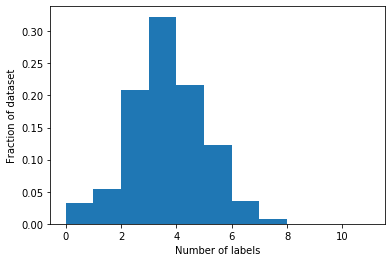

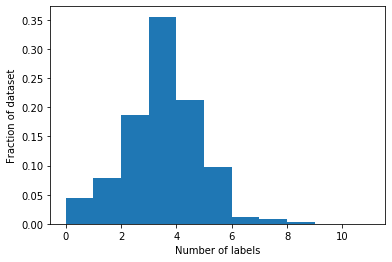

In [32]:
%matplotlib inline

from matplotlib import pyplot as plt


def plot_label_frequency(L):
    plt.hist(
        (L != ABSTAIN).sum(axis=1),
        density=True,
        bins=range(L.shape[1])
    )
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)
plot_label_frequency(L_dev)

### Interpretation

The overall label coverage looks good. Now we need to look at each label's coverage.

## Analyze the Labeling Functions' Performance

Overall label coverage is good but we need to make sure the distribution of our LF output is approximately even otherwise the label model won't have enough data with which to make good inferences about how LFs relate.

To help with this, we first prepare a `DataFrame` of label function names and their corresponding text labels to add to the `LFAnalysis.lf_summary` output to make it clearer what the coverage is for each label. 

In [33]:
# Prepare a name/label DataFrame to join to the LF Summary DataFrame below
lf_names = [lf.name for lf in lfs]
lf_labels = [lf._resources['label'] for lf in lfs]
lf_label_names = [{'Labels': number_to_name_dict[l]} for l in lf_labels]
label_name_df = pd.DataFrame(lf_label_names, index=lf_names)

label_name_df

,Labels
keyword_sdk_field_full_name,API
keyword_api_field_full_name,API
keyword_walkthrough_walk through_field_full_name_description_readme,API
keyword_skill_skills_field_full_name_description_readme,API
keyword_kit_kits_field_description_readme,API
keyword_extension_field_description_readme,API
keyword_amazon_field_description_readme,API
keyword_aws_field_full_name_description,API
keyword_integrate_integration_field_full_name_description_readme,API
keyword_/ion_field_full_name,GENERAL


### Run our `LFAnalysis` with Labels

Now we can run the LFAnalysis, get the summary and join our label names to see a clear indication of how well we're covering each label.

In [34]:
from snorkel.labeling import LFAnalysis

# Run the LF analysis on the gold labeled data
dev_lfa = LFAnalysis(L=L_dev, lfs=lfs)
dev_lfa_df = dev_lfa.lf_summary(Y=dev_labels.values)
dev_lfa_df['name'] = dev_lfa_df.index

# Join the label names in because the 'Polarity' field is confusing
lfa_label_df = dev_lfa_df.join(label_name_df)
lfa_label_df

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.,name,Labels
keyword_sdk_field_full_name,0,[1],0.044944,0.044944,0.000000,12,0,1.000000,keyword_sdk_field_full_name,API
keyword_api_field_full_name,1,[1],0.018727,0.018727,0.000000,5,0,1.000000,keyword_api_field_full_name,API
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.041199,0.041199,0.000000,10,1,0.909091,keyword_walkthrough_walk through_field_full_na...,API
keyword_skill_skills_field_full_name_description_readme,3,[1],0.074906,0.074906,0.000000,19,1,0.950000,keyword_skill_skills_field_full_name_descripti...,API
keyword_kit_kits_field_description_readme,4,[1],0.149813,0.146067,0.003745,33,7,0.825000,keyword_kit_kits_field_description_readme,API
keyword_extension_field_description_readme,5,[1],0.059925,0.059925,0.003745,15,1,0.937500,keyword_extension_field_description_readme,API
keyword_amazon_field_description_readme,6,[1],0.741573,0.726592,0.018727,181,17,0.914141,keyword_amazon_field_description_readme,API
keyword_aws_field_full_name_description,7,[1],0.827715,0.771536,0.000000,215,6,0.972851,keyword_aws_field_full_name_description,API
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.179775,0.179775,0.000000,47,1,0.979167,keyword_integrate_integration_field_full_name_...,API
keyword_/ion_field_full_name,9,[0],0.018727,0.018727,0.018727,5,0,1.000000,keyword_/ion_field_full_name,GENERAL


## Determine Coverage by Label

Now we can group by the label and determine the raw count correct, incorrect and total. This will give us an idea of coverage per label.

In [35]:
g_lf_df = lfa_label_df.groupby('Labels').agg({'Correct': 'sum', 'Incorrect': 'sum'})
g_lf_df['Total LFs'] = g_lf_df['Correct'] + g_lf_df['Incorrect']
sum_total_lf = g_lf_df['Total LFs'].sum()
g_lf_df['Total LF Ratio'] = g_lf_df['Total LFs'] / sum_total_lf
g_lf_df['Total Correct Ratio'] = g_lf_df['Correct'] / sum_total_lf

g_lf_df

,Correct,Incorrect,Total LFs,Total LF Ratio,Total Correct Ratio
Labels,,,,,
API,755,44,799,0.993781,0.939055
GENERAL,5,0,5,0.006219,0.006219


## Compare to Gold Label Coverage

We need to compare this LF coverage to the raw gold label coverage, which will give us an idea of the disparity between the two.

In [36]:
dev_g_df = dev_df.groupby('label').agg({'full_name': 'count'})
dev_g_df

sum_total_labels = dev_g_df['full_name'].sum()
dev_g_df['Total Hand Label Ratio'] = dev_g_df['full_name'] / sum_total_labels
dev_g_df.columns = ['Total Labels', 'Total Hand Label Ratio']

dev_g_df

,Total Labels,Total Hand Label Ratio
label,,
API,235,0.88015
GENERAL,32,0.11985


In [37]:
combined_df = dev_g_df.join(g_lf_df)
combined_df

combined_df['LF / Label Ratio'] = combined_df['Total LF Ratio'] / combined_df['Total Hand Label Ratio']
combined_df['Correct LF / Label Ratio'] = combined_df['Total Correct Ratio'] / combined_df['Total Hand Label Ratio']

combined_df

,Total Labels,Total Hand Label Ratio,Correct,Incorrect,Total LFs,Total LF Ratio,Total Correct Ratio,LF / Label Ratio,Correct LF / Label Ratio
label,,,,,,,,,
API,235,0.88015,755,44,799,0.993781,0.939055,1.129104,1.066926
GENERAL,32,0.11985,5,0,5,0.006219,0.006219,0.051889,0.051889


### Interpretation

It looks like we are way over-covering `API` and way under covering `GENERAL`. Let's fix that!

## Determine Standout Tokens Per Class

Inspect the top 5 tokens in terms of TF-IDF per record then look for standouts per class.

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer


v = TfidfVectorizer()
m = v.fit_transform(dev_df['readme'])
index_to_word = dict([(value, key) for key, value in v.vocabulary_.items()])

term_rows = []
for row in m.toarray():
    words = []
    for i, val in enumerate(row):
        if val > 0:
            words.append((
                val,
                index_to_word[i]
            ))
    term_rows.append(
        [y[1] for y in sorted(words, key=lambda x: x[0], reverse=True)[0:5]]
    )

dev_df['top_terms'] = term_rows
df_short = dev_df[['full_name', 'description', 'label', 'top_terms', 'readme']]
api_df = df_short[df_short['label'] == 'GENERAL']

# See the READMEs
pd.set_option('display.max_colwidth', 300)
api_df = api_df[['full_name', 'description', 'label', 'top_terms', 'readme']]

api_df

,full_name,description,label,top_terms,readme
id,,,,,
127175475,aws/mit-0,"The ""MIT No Attribution"" (MIT-0) License",GENERAL,"[secretcache, secrets, caching, go, cache]",## AWS Secrets Manager Go Caching Client\n\nThe AWS Secrets Manager Go caching client enables in-process caching of secrets for Go applications.\n\n## Getting Started\n\n### Required Prerequisites\nTo use this client you must have:\n\n* **A Go development environment**\n\n If you do not have on...
174581847,opendistro-for-elasticsearch/index-management,Open Distro for Elasticsearch Index Management,GENERAL,[],
30425338,c9/c9.ide.recentfiles,"The repository for c9.ide.recentfiles, a Cloud9 core plugin",GENERAL,"[corretto, openjdk, the, release, branch]","## Corretto 8\n\nAmazon Corretto is a no-cost, multiplatform, production-ready distribution of the Open Java Development Kit (OpenJDK). Corretto is used internally at Amazon for production services. With Corretto, you can develop and run Java applications on operating systems such as Amazon Linu..."
30425323,c9/c9.ide.openfiles,"The repository for c9.ide.openfiles, a Cloud9 core plugin",GENERAL,"[the, robomaker, ros1, bundle, robot]",# AWS RoboMaker Sample Application - Navigation and Person Detection\n\nThis application demonstrates the use of Amazon Rekognition to recognize people's faces\nand Amazon Polly to synthesize speech.\n\n\n_RoboMaker sample applications include third-party software licensed under open-source lice...
209768943,awslabs/analyze-binary-tools,Binary analysis tools and frameworks,GENERAL,"[sudo, engagement, upgrade, pip, predictive]",# Predictive User Engagement solution\nPredictive User Engagement (PUE) combines two fully managed AWS services and enables developers to quickly and easily add personalization to their web and mobile applications. Developers can combine predictions and recommendations with real-time notificatio...
107505869,firecracker-microvm/firecracker,Secure and fast microVMs for serverless computing.,GENERAL,"[ros2, ros, utils, workspace, branch]",# AWS Utils Library for ROS2\n\n## Overview\nThis is the common library for all of AWS RoboMaker ROS2 packages.\nIt builds on top of the generic interfaces defined by [utils-common](https://github.com/aws-robotics/utils-common) to provide ROS2-specific helper functions and classes implementation...
103439642,amzn/ion-hash-java,A Java implementation of Amazon Ion Hash.,GENERAL,"[magento, pay, alexa, php, delivery]",## Extension to enable Amazon Pay Alexa features on Magento 2\n\n[Learn More about Amazon Pay](https://pay.amazon.com/sp/magento)\n\n### Pre-Requisites\n* Magento 2.2.4 and above\n* Amazon Pay module enabled\n\n## Alexa Delivery Notifications\nThe Alexa Delivery Notifications feature lets you pr...
4225718,c9/node-netutil,"utils to find free ports in a range, checking if a port is open, etc",GENERAL,[],
54621372,amzn/amazon-dsstne,Deep Scalable Sparse Tensor Network Engine (DSSTNE) is an Amazon developed library for building Deep Learning (DL) machine learning (ML) models,GENERAL,"[sketch, constructor, page, artboard, color]","# Sketch Constructor\n\nThis library provides helpers and classes that make it easy to read/write/manipulate Sketch files in Javascript, without Sketch installed!\n\n## ⚠️ Warning ⚠️\nThis library is a work in progress, use at your own risk. But feel free to help out where you see bugs or incomp..."


## New LFs for API

We need some new LFs for API, so lets look at common n-grams of consequence for that class.

In [39]:
# Cloud9 is a GENERAL purpose project
cloud9_lf = make_keyword_lf(
    keywords=['cloud9', 'c9'],
    field=['full_name', 'description'],
    label=GENERAL,
)

# Open Distro is GENERAL
open_distro_lf = make_keyword_lf(
    keywords=['opendistro','open distro'],
    field=['full_name', 'description', 'readme'],
    label=GENERAL,
)

library_lf = make_keyword_lf(
    keywords=['library for'],
    field=['description'],
    label=GENERAL,
)

git_lf = make_keyword_lf(
    keywords=['protocol'],
    field=['full_name', 'description'],
    label=GENERAL,
)

# Add the LFs to one large list
lfs = [
    sdk_lf,
    api_lf,
    walkthrough_lf,
    skill_lf,
    kit_lf,
    extension_lf,
    amazon_lf,
    aws_lf,
    integration_lf,
    ion_lf,
    sample_lf,
    demo_lf,
    cloud9_lf,
    open_distro_lf,
    library_lf,
    git_lf,
]
lfs

# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 496/496 [00:00<00:00, 864.56it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_sdk_field_full_name,0,[1],0.044944,0.044944,0.000000,12,0,1.000000
keyword_api_field_full_name,1,[1],0.018727,0.018727,0.000000,5,0,1.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.041199,0.041199,0.003745,10,1,0.909091
keyword_skill_skills_field_full_name_description_readme,3,[1],0.074906,0.074906,0.000000,19,1,0.950000
keyword_kit_kits_field_description_readme,4,[1],0.149813,0.146067,0.014981,33,7,0.825000
keyword_extension_field_description_readme,5,[1],0.059925,0.059925,0.003745,15,1,0.937500
keyword_amazon_field_description_readme,6,[1],0.741573,0.730337,0.048689,181,17,0.914141
keyword_aws_field_full_name_description,7,[1],0.827715,0.771536,0.011236,215,6,0.972851
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.179775,0.179775,0.003745,47,1,0.979167
keyword_/ion_field_full_name,9,[0],0.018727,0.018727,0.018727,5,0,1.000000


In [40]:
train_lf_summary = LFAnalysis(L=L_train, lfs=lfs).lf_summary()
train_lf_summary

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_sdk_field_full_name,0,[1],0.062500,0.062500,0.000000
keyword_api_field_full_name,1,[1],0.020161,0.020161,0.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.044355,0.044355,0.000000
keyword_skill_skills_field_full_name_description_readme,3,[1],0.074597,0.072581,0.002016
keyword_kit_kits_field_description_readme,4,[1],0.151210,0.149194,0.004032
keyword_extension_field_description_readme,5,[1],0.078629,0.078629,0.002016
keyword_amazon_field_description_readme,6,[1],0.778226,0.768145,0.030242
keyword_aws_field_full_name_description,7,[1],0.844758,0.814516,0.022177
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.193548,0.193548,0.012097
keyword_/ion_field_full_name,9,[0],0.006048,0.006048,0.006048


In [41]:
train_lf_summary['Polarity'] = train_lf_summary['Polarity'].apply(lambda x: x[0])

gen_lf_summary = train_lf_summary[train_lf_summary['Polarity'] == 0]
api_lf_summary = train_lf_summary[train_lf_summary['Polarity'] == 1]

gen_lf_summary

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_/ion_field_full_name,9,0,0.006048,0.006048,0.006048
keyword_cloud9_c9_field_full_name_description,12,0,0.042339,0.022177,0.022177
keyword_opendistro_open distro_field_full_name_description_readme,13,0,0.008065,0.004032,0.004032
keyword_library for_field_description,14,0,0.012097,0.010081,0.010081
keyword_protocol_field_full_name_description,15,0,0.006048,0.004032,0.004032


In [42]:
gen_lf_summary.agg('Coverage').sum(), gen_lf_summary.agg('Overlaps').sum(), gen_lf_summary.agg('Conflicts').sum()

(0.07459677419354838, 0.046370967741935484, 0.046370967741935484)

In [43]:
api_lf_summary

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_sdk_field_full_name,0,1,0.062500,0.062500,0.000000
keyword_api_field_full_name,1,1,0.020161,0.020161,0.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,1,0.044355,0.044355,0.000000
keyword_skill_skills_field_full_name_description_readme,3,1,0.074597,0.072581,0.002016
keyword_kit_kits_field_description_readme,4,1,0.151210,0.149194,0.004032
keyword_extension_field_description_readme,5,1,0.078629,0.078629,0.002016
keyword_amazon_field_description_readme,6,1,0.778226,0.768145,0.030242
keyword_aws_field_full_name_description,7,1,0.844758,0.814516,0.022177
keyword_integrate_integration_field_full_name_description_readme,8,1,0.193548,0.193548,0.012097
keyword_sample_field_full_name_description_readme,10,1,0.661290,0.661290,0.028226


In [44]:
api_lf_summary.agg('Coverage').sum(), api_lf_summary.agg('Overlaps').sum(), api_lf_summary.agg('Conflicts').sum()

(3.183467741935484, 3.139112903225806, 0.12701612903225806)

In [46]:
dev_df

,full_name,description,created_at,updated_at,homepage,size,stargazers_count,watchers,forks,open_issues,default_branch,language,has_pages,archived,disabled,license,readme,label,top_terms
id,,,,,,,,,,,,,,,,,,,
111599613,alexa/skill-sample-nodejs-salesforce,"This project demonstrates how to build an Alexa private skill that integrates with your Salesforce data, utilizing account linking and a personal voice code.",2017-11-21 20:46:50,2020-02-04 19:14:40,,62,24,24,38,4,master,JavaScript,False,False,False,Other,"# Overview\n\nASK Toolkit for Visual Studio Code is an extension that that makes it easier to develop and deploy Alexa Skills. You can use the ASK toolkit to call the ASK command line interface (CLI) from within VS Code, and can see the results in VS Code's integrated terminal. This allows you t...",API,"[ask, toolkit, vs, alexa, the]"
157451858,aws/aws-iot-device-sdk-java-v2,Next generation AWS IoT Client SDK for Java using the AWS Common Runtime,2018-11-13 21:50:23,2020-02-19 19:50:44,,131,6,6,7,2,master,Java,False,False,False,Apache License 2.0,## AWS IoT SDK for Node.js v2\n\nNext generation AWS IoT Client SDK for Node.js using the AWS Common Runtime\n\n## License\n\nThis library is licensed under the Apache 2.0 License. \n,API,"[iot, js, node, sdk, generation]"
110872803,awsdocs/aws-directory-service-admin-guide,The open source version of the AWS Directory Service docs. You can submit feedback & requests for changes by submitting issues in this repo or by making proposed changes & submitting a pull request.,2017-11-15 18:48:22,2020-02-22 01:13:03,,401,9,9,24,4,master,,False,False,False,Other,## Amazon GameLift Developer Guide\n\nThe open source version of the Amazon GameLift docs. You can submit feedback & requests for changes by submitting issues in this repo or by making proposed changes & submitting a pull request.\n\n## License Summary\n\nThe documentation is made available unde...,API,"[gamelift, the, license, submitting, changes]"
130122117,aws-samples/aws-safe-lambda-deployments,Safe Deployments with AWS Lambda,2018-04-18 21:08:36,2020-02-15 20:00:12,https://aws.amazon.com/blogs/compute/implementing-safe-aws-lambda-deployments-with-aws-codedeploy/,11,16,16,28,2,master,JavaScript,False,False,False,Other,"## Headpose Estimator Apache Mxnet\n\nHead Pose estimator using Apache MXNet. HeadPose_ResNet50_Tutorial.ipynb helps you to walk through an end-to-end work flow of developing a CNN model from the scratch including data augmentation, fine-tuning, saving check-point model artifacts, validation and...",API,"[headpose, entry, estimator, point, script]"
197279317,aws-samples/aws-amplify-swiftui-demo,Get started using Amplify and SwiftUI,2019-07-16 23:01:42,2020-02-03 14:24:19,,21,15,15,3,0,master,Swift,False,False,False,Other,"## Amazon Cloudwatch Container Insights\n\nCloudWatch Agent Dockerfile and K8s YAML templates for CloudWatch Container Insights. \nFor more information about deploying Container Insights, see the [deployment documentation](https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/deploy-...",API,"[insights, container, cloudwatch, agent, amazoncloudwatch]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158472686,alexa/skill-sample-nodejs-trivia-pal,Alexa Skill Sample to learn how to use advanced dialog management. It creates a trivia dynamically from an array of questions and answers,2018-11-21 01:21:46,2019-07-08 13:49:36,,100,4,4,5,0,master,JavaScript,False,False,False,Other,## Skill Sample - Baby Activity\n\nThis is Alexa Skill helper sample code for Baby Activity Skill API. This contains sample implementation of Alexa.Health.* interfaces associated with Baby Activity Skills API. It shows the profile report and request/response handling of a skill implementing Alex...,API,"[baby, activity, skill, skills, health]"
91381430,awslabs/aws-refarch-cross-account-pipeline,"The Cloudformation Templates guides the users to setup a codepipeline in Account-A, CodeComm

## Exploratory Data Analysis: Size of Project

We've hit the end of the road in our attempt to create `GENERAL` label `LabelingFunctions` using keyword search. Next up we're going to perform exploratory data analysis to look at the distribution of different numeric properties to use as strategies for creating LFs.

First we're going to look at project size in kilobytes to see if this can be a strategy for `LabelingFunctions`.

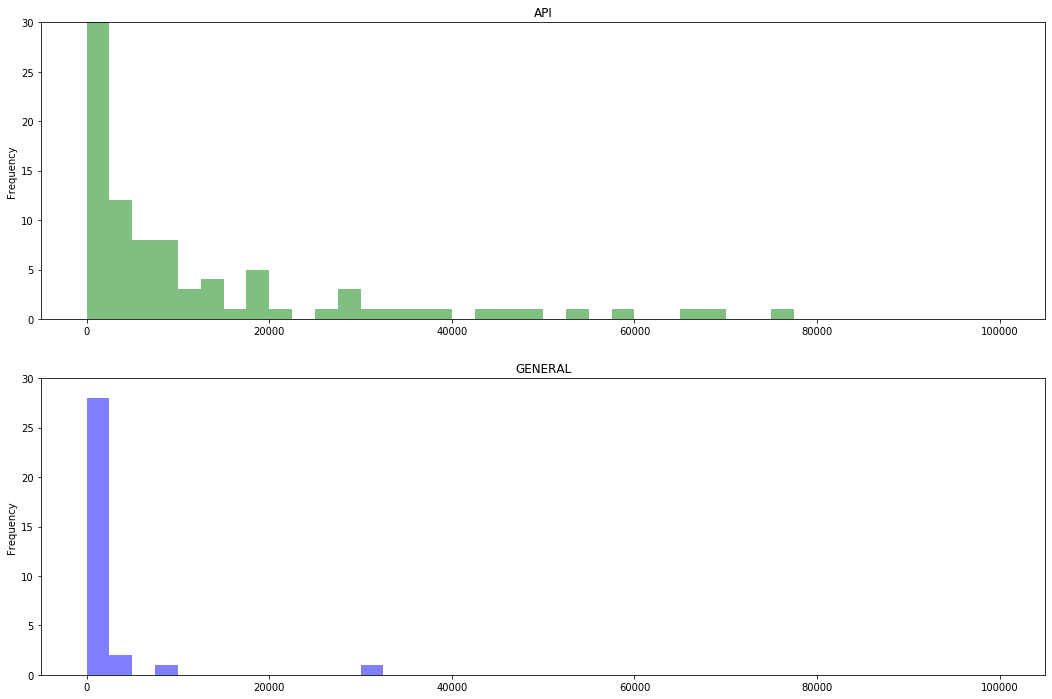

In [75]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn


# Separate the data by label
api_dev_df = dev_df[dev_df['label'] == 'API']
gen_dev_df = dev_df[dev_df['label'] == 'GENERAL']


# Create a dual histogram of different values to create LabelingFunctions
fig = plt.figure(figsize=(18, 12))

api_ax = fig.add_subplot(211)
api_dev_df[api_dev_df['size'] < 100000]['size'].plot.hist(
    bins   = 40,
    color  = 'green',
    alpha  = 0.5,
    ax     = api_ax,
    range  = (0, 100000),
    ylim   = (0, 30),
)
api_ax.title.set_text('API')

gen_ax = fig.add_subplot(212)
gen_dev_df[gen_dev_df['size'] < 100000]['size'].plot.hist(
    bins   = 40,
    color  = 'blue',
    alpha  = 0.5,
    ax     = gen_ax,
    range  = (0, 100000),
    ylim   = (0, 30),
)
gen_ax.title.set_text('GENERAL')

plt.show()

## LabelingFunction Results

You can see from the chart above of project size in kilobytes, which I've limited to <100K and to 30 items per bucket (max for the `API` label is actually 175), that Amazon's `GENERAL` (general purpose) open source projects tend to be quite small compared to their `GENERAL` projects. We can use this as a `LabelingFunction` strategy such that projects with > 35K are labeled `API` rather than `GENERAL`.

In [128]:
@labeling_function()
def repo_size_lf(x):
    return API if x.size > 35000 else ABSTAIN

## Automating Histograms

I don't want to paste the above code repeatedly so lets create a function to plot a histogram of a numeric field.

In [129]:
def plot_dual_hist(dev_df, col, max_x=None, max_y=None, figsize=(18, 12)):
    
    # Separate the data by label
    api_dev_df = dev_df[dev_df['label'] == 'API']
    gen_dev_df = dev_df[dev_df['label'] == 'GENERAL']

    # Create a dual histogram of different values to create LabelingFunctions
    fig = plt.figure(figsize=figsize)

    api_ax = fig.add_subplot(211)
    
    # Optionally filter the data
    if max_x:
        gen_dev_df = gen_dev_df[gen_dev_df[col] < max_x[1]]
    
    api_dev_df[col].plot.hist(
        bins   = 40,
        color  = 'green',
        alpha  = 0.5,
        ax     = api_ax,
        range  = max_x,
        ylim   = max_y,
    )
    api_ax.title.set_text('API')

    gen_ax = fig.add_subplot(212)
    
    gen_dev_df[col].plot.hist(
        bins   = 40,
        color  = 'blue',
        alpha  = 0.5,
        ax     = gen_ax,
        range  = max_x,
        ylim   = max_y,
    )
    gen_ax.title.set_text('GENERAL')

    plt.show()

## Exploring the other Numeric Fields

In the 

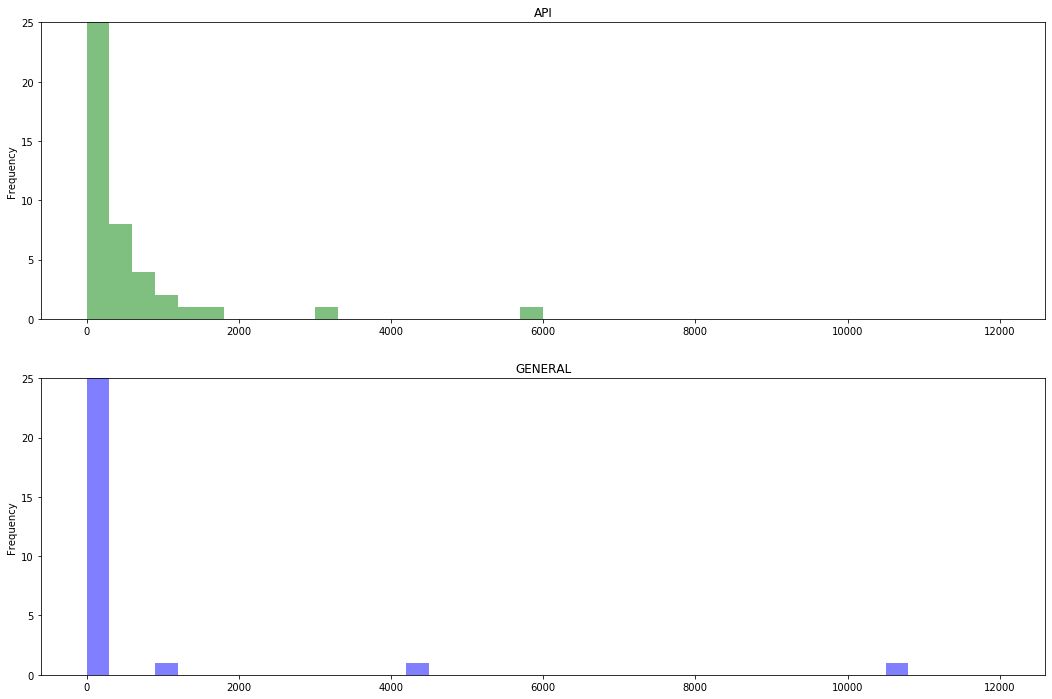

In [122]:
plot_dual_hist(dev_df, 'stargazers_count', max_y=(0, 25), max_x=(0, 12000))

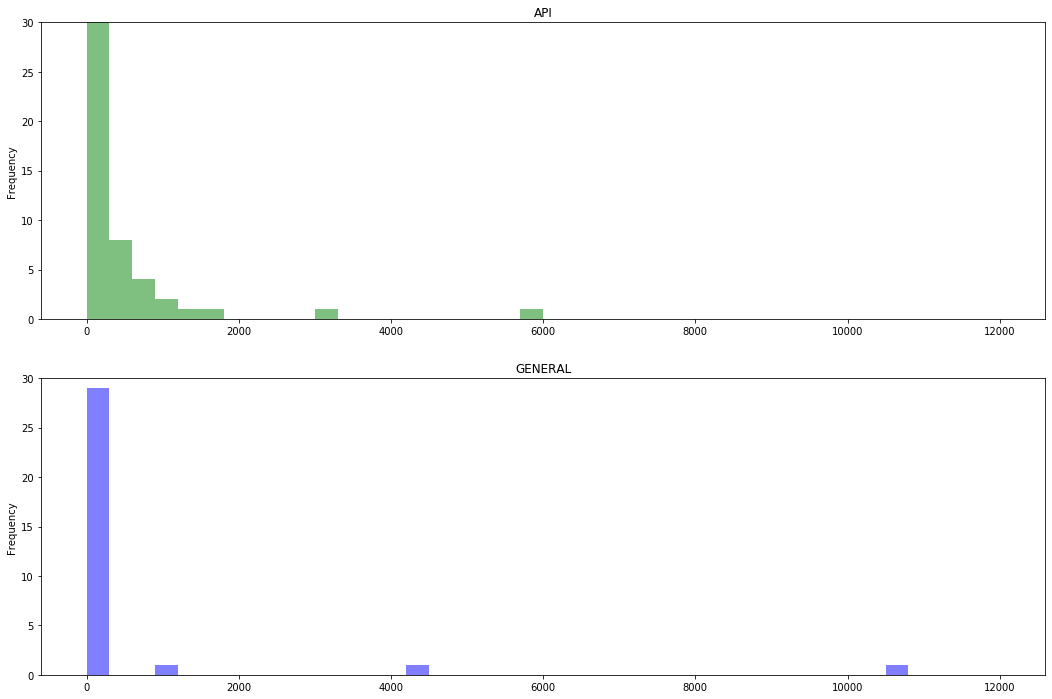

In [123]:
plot_dual_hist(dev_df, 'watchers', max_y=(0, 30), max_x=(0, 12000))

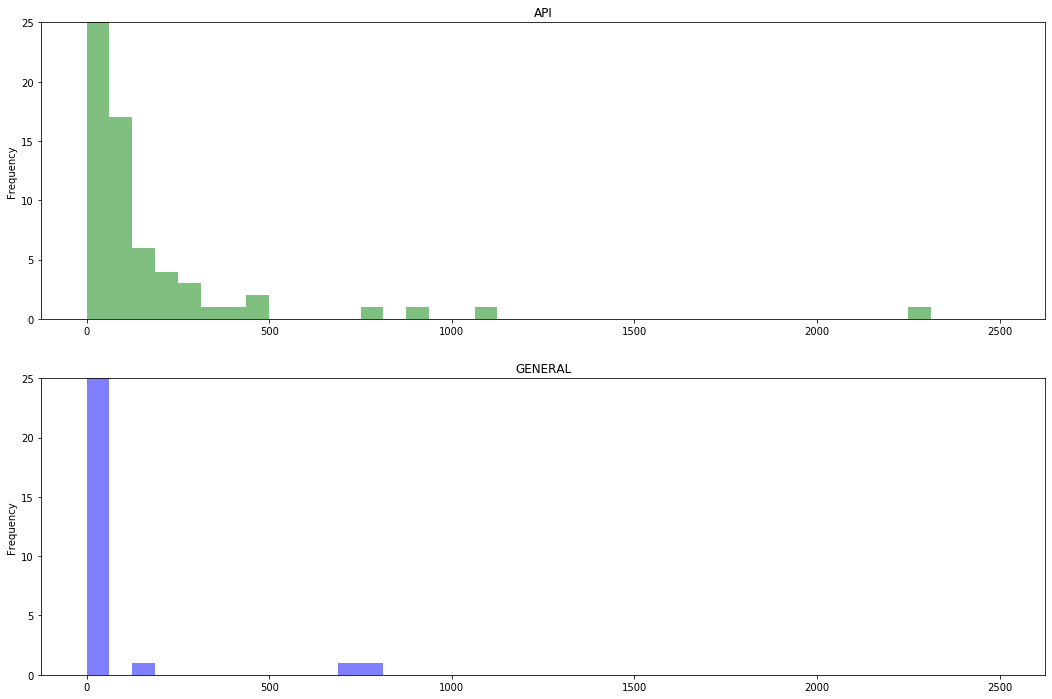

In [124]:
plot_dual_hist(dev_df, 'forks', max_y=(0, 25), max_x=(0, 2500))

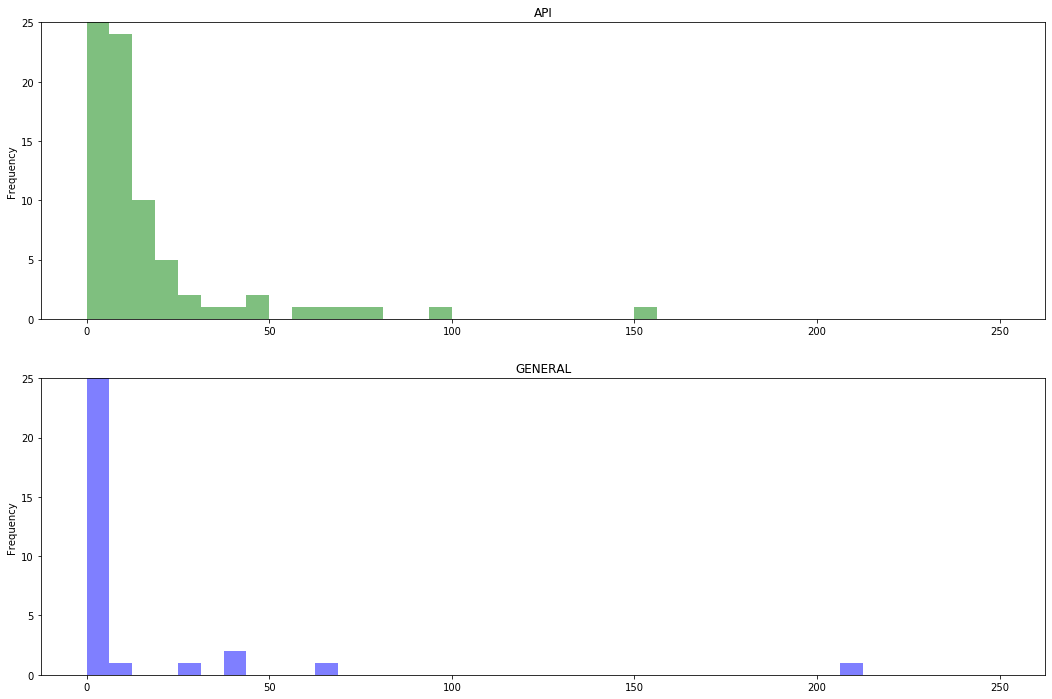

In [126]:
plot_dual_hist(dev_df, 'open_issues', max_y=(0, 25), max_x=(0, 250))